In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import (cross_val_score,
                                     cross_val_predict,
                                     StratifiedKFold,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split)
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             classification_report,
                             confusion_matrix,
                             roc_curve,
                             auc,
                             roc_auc_score,
                             precision_recall_curve,
                             f1_score)

In [2]:
base_credit = pd.read_csv('credit_risk_dataset.csv')

In [3]:
base_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [4]:
base_credit["person_emp_length"].fillna(base_credit["person_emp_length"].median(), inplace=True)

In [5]:
base_credit["loan_int_rate"].fillna(base_credit["loan_int_rate"].median(), inplace=True)

In [6]:
base_credit.drop_duplicates(inplace=True)

In [7]:
X_credit = base_credit[['person_age', 'person_income', 'person_home_ownership',
                        'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
                        'loan_int_rate', 'loan_percent_income',
                        'cb_person_default_on_file', 'cb_person_cred_hist_length']]
y_credit = base_credit['loan_status']

In [8]:
X_credit = pd.get_dummies(X_credit)

In [9]:
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(X_credit,y_credit, test_size = 0.3, random_state=84)

In [10]:
from xgboost import XGBClassifier

In [11]:
baseline_model = XGBClassifier(booster='gbtree', objective='binary:logistic',eval_metric='logloss' ,use_label_encoder=False, random_state=2)

In [12]:
# Obtain scores of cross-validation
scores = cross_val_score(baseline_model, X_credit, y_credit, cv=5)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))

Accuracy: [0.91 0.9  0.92 0.92 0.93]
Accuracy mean: 0.92


In [13]:
#Load Neural Networks Libraries

from keras import models
from keras import layers

In [14]:
number_of_features = len(X_credit_train.columns)

In [15]:
print(number_of_features)

26


In [17]:
# Building the Neural Networks

#Start neural network

network = models.Sequential()

#Add fully connected layer with ReLU activation function

network.add(layers.Dense(units=16, activation="relu", input_shape=(number_of_features,)))

#Add fully connected layer with ReLU activation function

network.add(layers.Dense(units=16, activation="relu"))

#Add fully connected layer with sigmoid activation function

network.add(layers.Dense(units=1, activation="sigmoid"))

#Compile the Neural Network

network.compile(loss="binary_crossentropy", #Cross-Entropy Loss Function
                optimizer='rmsprop', #Root Mean Square Propagation
                metrics=['accuracy'] #Performance measure using accurancy
               )

In [18]:
history = network.fit( X_credit_train,
                       y_credit_train,
                       epochs=1000, # Number os executions
                       verbose=0, # No output
                       batch_size=5000, # Number of observation per batch
                       validation_data=(X_credit_test, y_credit_test) # Test data using TensorFlow backend
                       )

In [19]:
# Making Predictions
predicted_target = network.predict(X_credit_test)

In [20]:
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
epoch_count = range(1, len(training_loss)+1)

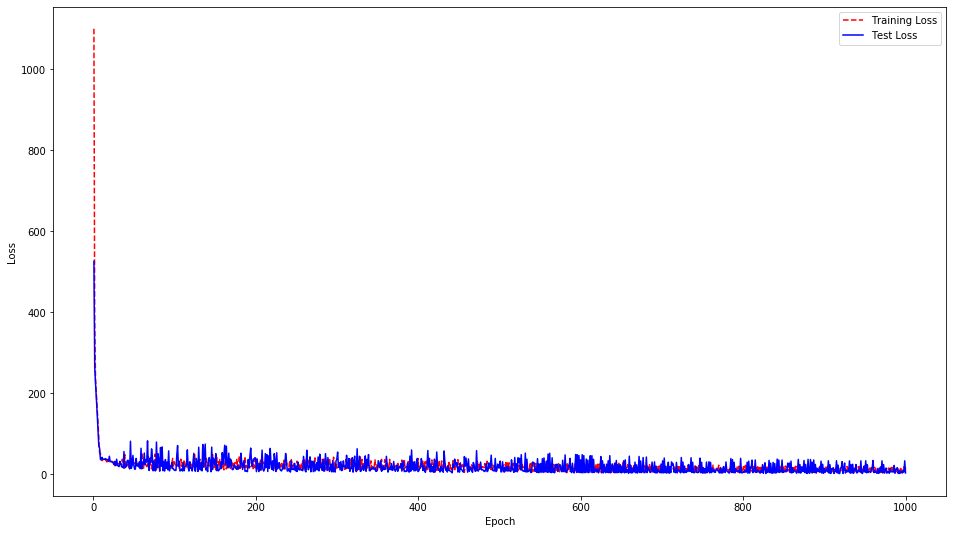

In [21]:
# Visualize Loss History
plt.figure(figsize=(16,9))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss","Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

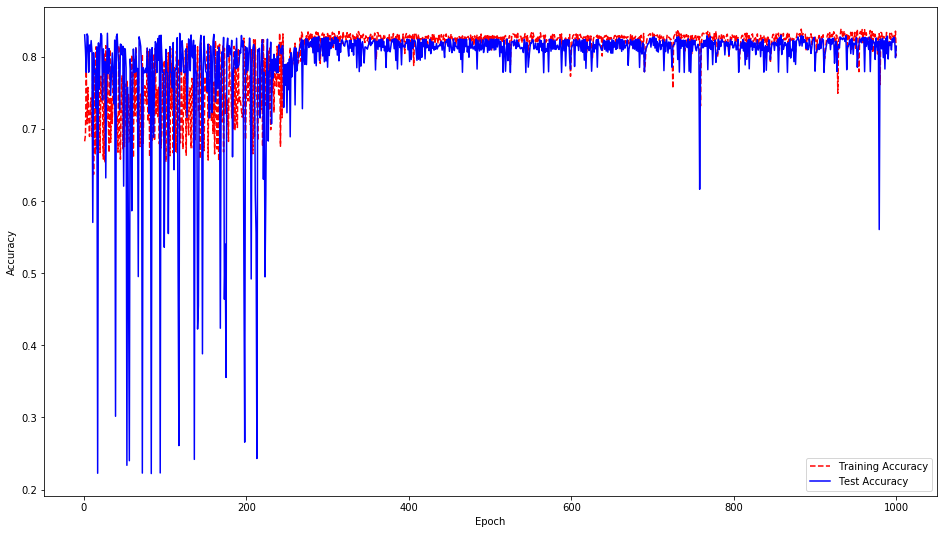

In [74]:
training_acc = history.history["accuracy"]
test_acc = history.history["val_accuracy"]
plt.figure(figsize=(16,9))
plt.plot(epoch_count, training_acc, "r--")
plt.plot(epoch_count, test_acc, "b-")
plt.legend(["Training Accuracy","Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [22]:
from sklearn.metrics import roc_curve
y_pred_keras = network.predict(X_credit_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_credit_test, y_pred_keras)

In [23]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

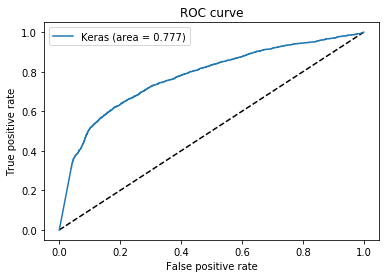

In [24]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [25]:
# Building A REGULARIZED Neural Networks
from keras import regularizers
#Start neural network

network_l2 = models.Sequential()

#Add fully connected layer with ReLU activation function

network_l2.add(layers.Dense(units=16, 
                         activation="relu",
                         kernel_regularizer=regularizers.l2(0.01),
                         input_shape=(number_of_features,)))

#Add fully connected layer with ReLU activation function

network_l2.add(layers.Dense(units=16,
                         activation="relu",
                         kernel_regularizer=regularizers.l2(0.01),
                         input_shape=(number_of_features,)))
#Add fully connected layer with sigmoid activation function

network_l2.add(layers.Dense(units=1, activation="sigmoid"))

#Compile the Neural Network

network_l2.compile(loss="binary_crossentropy", #Cross-Entropy Loss Function
                optimizer='rmsprop', #Root Mean Square Propagation
                metrics=['accuracy'] #Performance measure using accurancy
               )

In [26]:
history_l2 = network_l2.fit( X_credit_train,
                             y_credit_train,
                             epochs=1000, # Number os executions
                             verbose=0, # No output
                             batch_size=5000, # Number of observation per batch
                             validation_data=(X_credit_test, y_credit_test) # Test data using TensorFlow backend
                            )

In [27]:
training_loss_l2 = history_l2.history["loss"]
test_loss_l2 = history_l2.history["val_loss"]
epoch_count_l2 = range(1, len(training_loss_l2)+1)

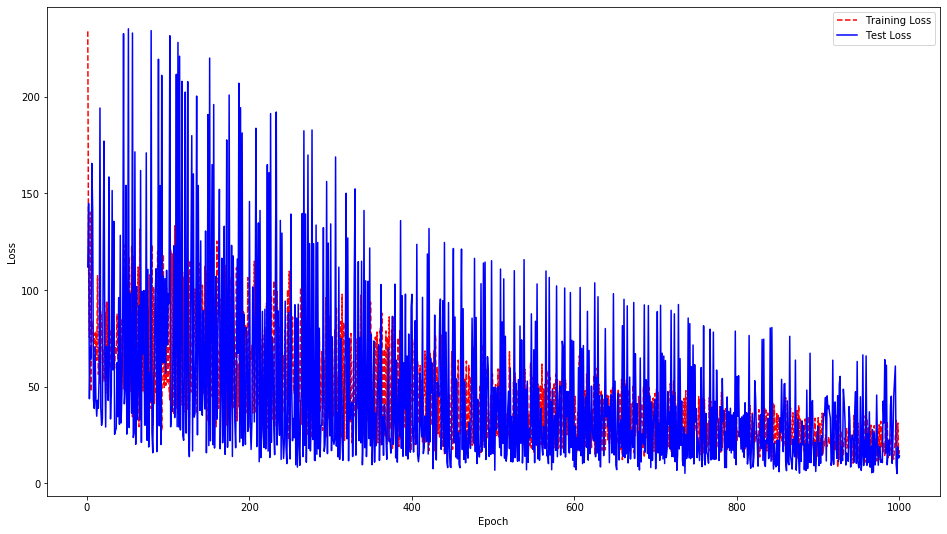

In [28]:
# Visualize Loss History
plt.figure(figsize=(16,9))
plt.plot(epoch_count_l2, training_loss_l2, "r--")
plt.plot(epoch_count_l2, test_loss_l2, "b-")
plt.legend(["Training Loss","Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

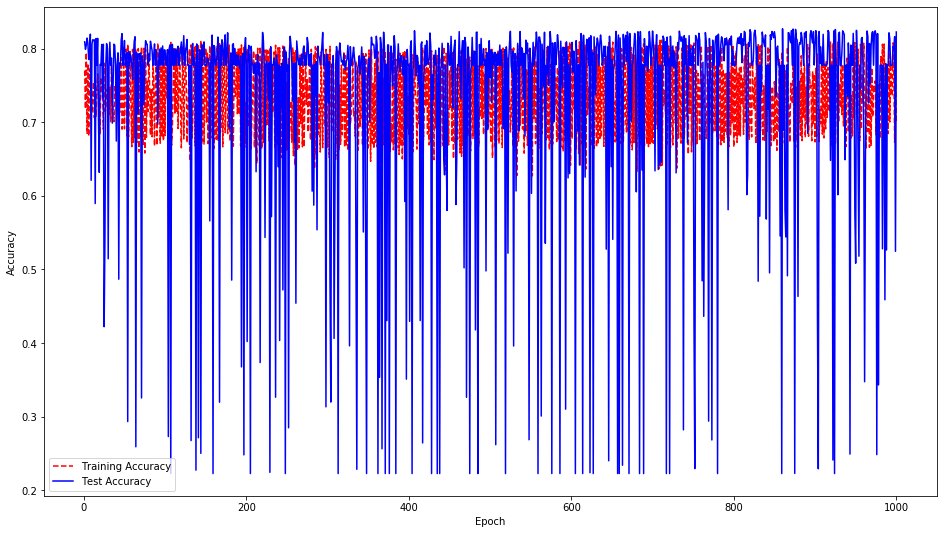

In [29]:
training_acc_l2 = history_l2.history["accuracy"]
test_acc_l2 = history_l2.history["val_accuracy"]
plt.figure(figsize=(16,9))
plt.plot(epoch_count_l2, training_acc_l2, "r--")
plt.plot(epoch_count_l2, test_acc_l2, "b-")
plt.legend(["Training Accuracy","Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [30]:
y_pred_keras_l2 = network_l2.predict(X_credit_test).ravel()
fpr_keras_l2, tpr_keras_l2, thresholds_keras_l2 = roc_curve(y_credit_test, y_pred_keras_l2)
auc_keras_l2 = auc(fpr_keras_l2, tpr_keras_l2)

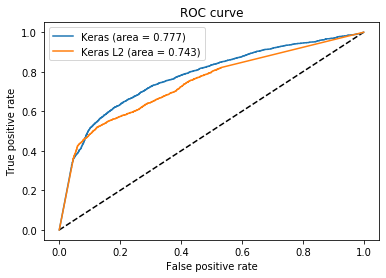

In [31]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras_l2, tpr_keras_l2, label='Keras L2 (area = {:.3f})'.format(auc_keras_l2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [32]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [33]:
# Set callback functions to early stop training and sabe best model so far
callback = [EarlyStopping(monitor="val_loss",patience=2),
            ModelCheckpoint(filepath="best_model.h5",
                            monitor="val_loss",
                            save_best_only=True
                            )]

In [34]:
history_es    = network.fit( X_credit_train,
                             y_credit_train,
                             epochs=1000, # Number os executions
                             callbacks=callback, # Early stopping
                             verbose=0, # No output
                             batch_size=5000, # Number of observation per batch
                             validation_data=(X_credit_test, y_credit_test) # Test data using TensorFlow backend
                            )

In [35]:
y_pred_keras_es = network.predict(X_credit_test).ravel()
fpr_keras_es, tpr_keras_es, thresholds_keras_es = roc_curve(y_credit_test, y_pred_keras_es)
auc_keras_es = auc(fpr_keras_es, tpr_keras_es)

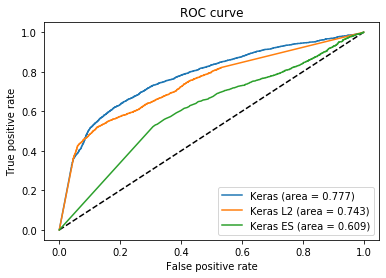

In [36]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras_l2, tpr_keras_l2, label='Keras L2 (area = {:.3f})'.format(auc_keras_l2))
plt.plot(fpr_keras_es, tpr_keras_es, label='Keras ES (area = {:.3f})'.format(auc_keras_es))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [38]:
def create_network():
    #Start neural network

    network = models.Sequential()

    #Add fully connected layer with ReLU activation function

    network.add(layers.Dense(units=16, activation="relu", input_shape=(number_of_features,)))

    #Add fully connected layer with ReLU activation function

    network.add(layers.Dense(units=16, activation="relu"))

    #Add fully connected layer with sigmoid activation function

    network.add(layers.Dense(units=1, activation="sigmoid"))

    #Compile the Neural Network

    network.compile(loss="binary_crossentropy", #Cross-Entropy Loss Function
                optimizer='rmsprop', #Root Mean Square Propagation
                metrics=['accuracy'] #Performance measure using accurancy
               )
    return network

In [39]:
# K-Fold Cross-Validation of Neural Networks
# Wraps a Neural Networks to be used in Sklearn
from keras.wrappers.scikit_learn import KerasClassifier
neural_network = KerasClassifier(build_fn=create_network,
                                 epochs=1000, # Number os executions
                                 verbose=0, # No output
                                 batch_size=5000 # Number of observation per batch
                                )

In [40]:
# Obtain scores of cross-validation
scores_nn = cross_val_score(neural_network, X_credit_train, y_credit_train, cv=5)

# Display accuracy
print('Accuracy:', np.round(scores_nn, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores_nn.mean()))

Accuracy: [0.83 0.79 0.73 0.83 0.79]
Accuracy mean: 0.79


In [109]:
def create_network_2(optimizer="rmsprop"):
    #Start neural network

    network = models.Sequential()

    #Add fully connected layer with ReLU activation function

    network.add(layers.Dense(units=16, activation="relu", input_shape=(number_of_features,)))

    #Add fully connected layer with ReLU activation function

    network.add(layers.Dense(units=16, activation="relu"))

    #Add fully connected layer with sigmoid activation function

    network.add(layers.Dense(units=1, activation="sigmoid"))

    #Compile the Neural Network

    network.compile(loss="binary_crossentropy", #Cross-Entropy Loss Function
                optimizer=optimizer, 
                metrics=['accuracy'] #Performance measure using accurancy
               )
    return network

In [110]:
neural_network_2 = KerasClassifier(build_fn=create_network_2,
                                   verbose=0
                                   )

In [111]:
# hyperparameter space
epochs  = [100,200,500,1000]
batches = [1000, 2000, 5000]
optimizers = ["rmsprop","adam"]

In [114]:
hyperparameters = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)

In [115]:
grid = GridSearchCV(estimator=neural_network_2, param_grid=hyperparameters)
grid_result = grid.fit(X_credit_train, y_credit_train)

In [116]:
grid_result.best_params_

{'batch_size': 1000, 'epochs': 1000, 'optimizer': 'rmsprop'}

In [118]:
history_opt    = network.fit( X_credit_train,
                             y_credit_train,
                             epochs=1000, # Number os executions
                             verbose=0, # No output
                             batch_size=1000, # Number of observation per batch
                             validation_data=(X_credit_test, y_credit_test) # Test data using TensorFlow backend
                            )

In [120]:
y_pred_keras_opt = network.predict(X_credit_test).ravel()
fpr_keras_opt, tpr_keras_opt, throptholds_keras_opt = roc_curve(y_credit_test, y_pred_keras_opt)
auc_keras_opt = auc(fpr_keras_opt, tpr_keras_opt)

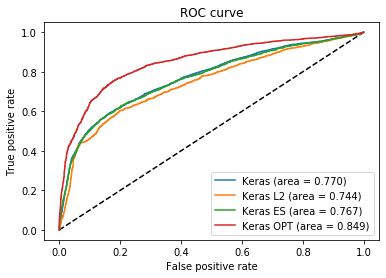

In [121]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras_l2, tpr_keras_l2, label='Keras L2 (area = {:.3f})'.format(auc_keras_l2))
plt.plot(fpr_keras_es, tpr_keras_es, label='Keras ES (area = {:.3f})'.format(auc_keras_es))
plt.plot(fpr_keras_opt, tpr_keras_opt, label='Keras OPT (area = {:.3f})'.format(auc_keras_opt))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Vanishing/Exploding Gradients Problem


In [41]:
def logit(z):
    return 1 / (1 + np.exp(-z))

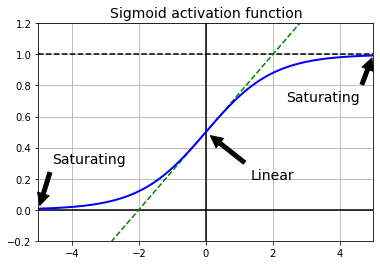

In [43]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

# Initialization Schema

In [45]:
import keras

In [46]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [47]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [48]:

init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

# Nonsaturating Activation Functions

In [49]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

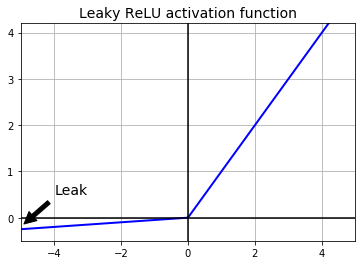

In [50]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [51]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [52]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [54]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

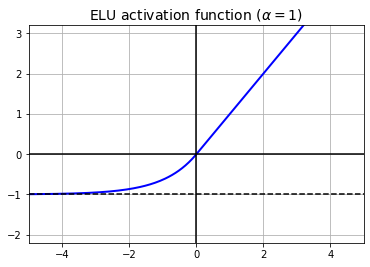

In [56]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

In [59]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [61]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

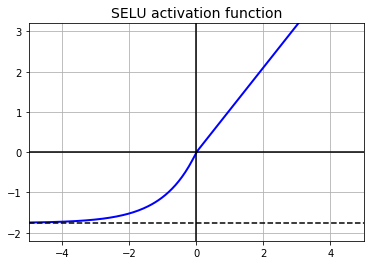

In [62]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

# Faster Optimizers

In [69]:
## Momentum optimization

In [63]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [70]:
## Nesterov Accelerated Gradient

In [75]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [ ]:
## AdaGrad

In [64]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

In [76]:
## RMSProp

In [65]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [77]:
## Adam Optimization

In [66]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [78]:
## Adamax Optimization

In [67]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [79]:
## Nadam Optimization

In [68]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

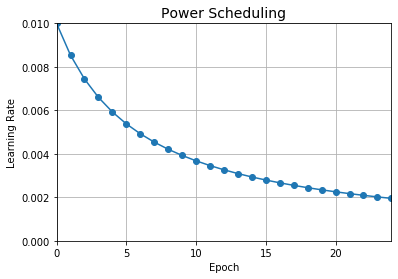

In [81]:
n_epochs = 25
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [82]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [83]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [88]:
model = keras.models.Sequential([
                                 keras.layers.Dense(units=16, activation="relu", input_shape=(number_of_features,)),
                                 keras.layers.Dense(16, activation="selu", kernel_initializer="lecun_normal"),
                                 keras.layers.Dense(16, activation="selu", kernel_initializer="lecun_normal"),
                                 keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])